In [1]:
# !pip install -v python-mecab-ko

In [209]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import urllib.request
import mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [210]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv", filename="finance_data.csv")

('finance_data.csv', <http.client.HTTPMessage at 0x7f3240bf7050>)

In [211]:
data = pd.read_csv('finance_data.csv')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4846


In [212]:
data

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,런던 마켓워치 -- 은행주의 반등이 FTSE 100지수의 약세를 상쇄하지 못하면서 ...
4842,neutral,Rinkuskiai's beer sales fell by 6.5 per cent t...,린쿠스키아의 맥주 판매량은 416만 리터로 6.5% 감소했으며 카우노 알루스의 맥주...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,"영업이익은 2007년 68.8 mn에서 35.4 mn으로 떨어졌으며, 선박 판매 이..."
4844,negative,Net sales of the Paper segment decreased to EU...,페이퍼 부문 순매출은 2008년 2분기 241.1 mn에서 2009년 2분기 221...


In [213]:
data['labels'] = data['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
data[:5]

,labels,sentence,kor_sentence
0,0,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [214]:
del data['sentence']

In [215]:
data[:5]

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [216]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   labels        4846 non-null   int64 
 1   kor_sentence  4846 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [217]:
print('결측값 여부 :',data.isnull().values.any())

결측값 여부 : False


In [218]:
print('kor_sentence 열의 유니크한 값 :',data['kor_sentence'].nunique())

kor_sentence 열의 유니크한 값 : 4827


In [219]:
duplicate = data[data.duplicated()]

In [220]:
duplicate

,labels,kor_sentence
1099,0,이 발표 내용에 대한 책임은 전적으로 발행자에게 있습니다.
1394,0,"핀란드 헬싱키에 본사를 둔 레민카이넨 그룹은 토목 공학, 건축 계약, 기술 건축 서..."
1416,0,"이 보고서는 블랙 앤 데커, 피스카스, 피스카스 브랜드, 후스크바르나 아웃도어 프로..."
2396,0,알스트롬의 주가는 나스닥 OMX 헬싱키에서 인용되고 있다.
2567,0,SSH 통신 보안 코퍼레이션은 핀란드 헬싱키에 본사를 두고 있다.
2889,0,재정적인 세부사항은 공개되지 않았다.
2890,0,재정적인 세부사항은 공개되지 않았다.
2892,0,금융 조건은 공개되지 않았다.
3050,0,재정적인 세부사항은 제공되지 않았다.
3051,0,재정적인 세부사항은 공개되지 않았다.


In [221]:
# 중복 제거
data.drop_duplicates(subset=['kor_sentence'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4827


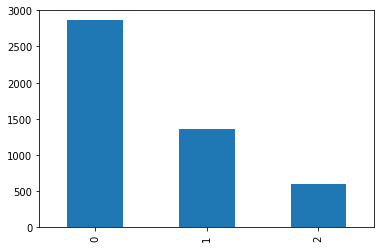

In [222]:

data['labels'].value_counts().plot(kind='bar')

In [223]:
print('레이블의 분포')
print(data.groupby('labels').size().reset_index(name='count'))

레이블의 분포
   labels  count
0       0   2861
1       1   1362
2       2    604


In [224]:
print(f'중립의 비율 = {round(data["labels"].value_counts()[0]/len(data) * 100,3)}%')
print(f'긍정의 비율 = {round(data["labels"].value_counts()[1]/len(data) * 100,3)}%')
print(f'부정의 비율 = {round(data["labels"].value_counts()[2]/len(data) * 100,3)}%')

중립의 비율 = 59.271%
긍정의 비율 = 28.216%
부정의 비율 = 12.513%


In [225]:
mecab = mecab.MeCab()

In [226]:
data['tokenized'] = data['kor_sentence'].apply(mecab.morphs)

In [227]:
data

,labels,kor_sentence,tokenized
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로...","[Gran, 에, 따르, 면, ,, 그, 회사, 는, 회사, 가, 성장, 하, 고,..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...,"[테크노폴리스, 는, 컴퓨터, 기술, 과, 통신, 분야, 에서, 일, 하, 는, 회..."
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ...","[국제, 전자, 산업, 회사, 인, 엘코, 텍, 은, 탈린, 공장, 에서, 수십, ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...,"[새로운, 생산, 공장, 으로, 인해, 회사, 는, 예상, 되, 는, 수요, 증가,..."
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4...","[2009, -, 2012, 년, 회사, 의, 업데이트, 된, 전략, 에, 따르, ..."
...,...,...,...
4841,2,런던 마켓워치 -- 은행주의 반등이 FTSE 100지수의 약세를 상쇄하지 못하면서 ...,"[런던, 마켓, 워치, --, 은행주의, 반, 등, 이, FTSE, 100, 지수,..."
4842,0,린쿠스키아의 맥주 판매량은 416만 리터로 6.5% 감소했으며 카우노 알루스의 맥주...,"[린, 쿠, 스키아, 의, 맥주, 판매량, 은, 416, 만, 리터, 로, 6, ...."
4843,2,"영업이익은 2007년 68.8 mn에서 35.4 mn으로 떨어졌으며, 선박 판매 이...","[영업, 이익, 은, 2007, 년, 68, ., 8, mn, 에서, 35, ., ..."
4844,2,페이퍼 부문 순매출은 2008년 2분기 241.1 mn에서 2009년 2분기 221...,"[페이퍼, 부문, 순, 매출, 은, 2008, 년, 2, 분기, 241, ., 1,..."


In [228]:
stopwords = ['으로', '면', '도', '는', '다', '의', '가', '이',
             '은', '한', '에', '하', '고', '을',
             '를', '인', '듯', '과', '와', '네',
             '들', '듯', '지', '임', '게','에서','시','위해']

def stopwords_(stop):
    return [i for i in stop if i not in stopwords]

In [229]:
stop_word = '거 링 이 디 스 전 거 명 곳 위 때 내 제 중 더 를 링 나 사 이 내 디 개 요 아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓'

other_words = stop_word.split()

def other_words_(stop):
    return [i for i in stop if i not in other_words]

In [230]:
# data.loc[:,'tokenized'].apply(stopwords_)

In [231]:
X_data = data['tokenized']
y_data = data['labels']
print('본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

본문의 개수: 4827
레이블의 개수: 4827


In [232]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)


In [233]:

print('훈련 샘플의 개수 :', len(X_train))
print('테스트 샘플의 개수 :', len(X_test))

훈련 샘플의 개수 : 3861
테스트 샘플의 개수 : 966


In [234]:
print('--------훈련 데이터의 비율-----------')
print(f'중립 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'긍정 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print(f'부정 = {round(y_train.value_counts()[2]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
중립 = 59.285%
긍정 = 28.205%
부정 = 12.51%


In [235]:

print('--------테스트 데이터의 비율-----------')
print(f'중립 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'긍정 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')
print(f'부정 = {round(y_test.value_counts()[2]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
중립 = 59.213%
긍정 = 28.261%
부정 = 12.526%


In [236]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)
print(X_train_encoded[:5])
print(X_test_encoded[:5])

[[390, 199, 4, 299, 170, 128, 2, 150, 15, 299, 170, 2075, 331, 10, 4, 1156, 5, 567, 29, 20, 22, 151, 10, 16, 14, 3, 1], [1157, 1158, 4, 92, 5, 43, 36, 50, 13, 47, 208, 16, 13, 3, 1], [5, 95, 2, 55, 7, 19, 1, 38, 44, 15, 48, 1, 52, 44, 22, 50, 13, 3, 1], [515, 4, 2076, 4504, 6, 84, 283, 157, 8, 609, 638, 160, 2, 2480, 474, 1066, 157, 6, 2077, 29, 20, 8, 284, 13, 3, 1], [165, 339, 7, 1426, 265, 76, 15, 1426, 332, 76, 699, 18, 475, 212, 1]]
[[868, 792, 7, 113, 140, 6, 88, 332, 27, 17, 12, 114, 77, 1], [97, 1917, 211, 184, 2, 4295, 2503, 23, 401, 24, 770, 6, 174, 364, 34, 16, 190, 61, 20, 5, 69, 28, 330, 7, 51, 13, 3, 1], [672, 160, 376, 882, 30, 238, 31, 4, 156, 2, 3463, 1088, 5, 21, 5286, 159, 2, 964, 12, 2873, 10, 4, 20, 5, 69, 1143, 13, 3, 1], [412, 38, 65, 150, 7, 58, 11, 231, 95, 2, 19, 1, 48, 206, 17, 15, 19, 1, 43, 206, 17, 18, 452, 3, 1], [71, 11, 43, 26, 511, 40, 653, 19, 205, 98, 571, 105, 1, 5241, 2, 1196, 328, 3118, 19, 37, 71, 6, 84, 271, 2474, 7, 71, 11, 19, 26, 123, 38, 26,

In [237]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(vocab_size)

8942


본문의 최대 길이 : 76
본문의 평균 길이 : 28.235431235431236


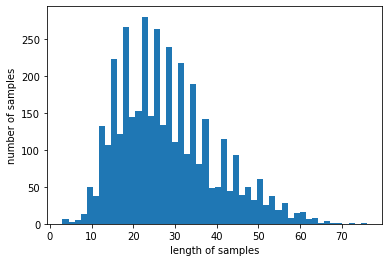

In [238]:
print('본문의 최대 길이 :',max(len(sent) for sent in X_train))
print('본문의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(sent) for sent in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [239]:

max_len = 76

In [240]:
X_train_encoded = pad_sequences(X_train_encoded, maxlen=max_len)
X_test_encoded = pad_sequences(X_test_encoded, maxlen=max_len)

In [241]:

X_train_encoded.shape

(3861, 76)

In [242]:
X_test_encoded.shape

(966, 76)

In [243]:

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [244]:

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [245]:
embedding_dim = 64
hidden_units = 64
num_classes = 3

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train_encoded, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)


Epoch 1/15
97/97 [==============================] - ETA: 0s - loss: 0.8757 - acc: 0.6159
Epoch 1: val_acc improved from -inf to 0.71281, saving model to best_model.h5
97/97 [==============================] - 15s 131ms/step - loss: 0.8757 - acc: 0.6159 - val_loss: 0.7120 - val_acc: 0.7128
Epoch 2/15
97/97 [==============================] - ETA: 0s - loss: 0.6049 - acc: 0.7338
Epoch 2: val_acc improved from 0.71281 to 0.72445, saving model to best_model.h5
97/97 [==============================] - 12s 120ms/step - loss: 0.6049 - acc: 0.7338 - val_loss: 0.6951 - val_acc: 0.7245
Epoch 3/15
97/97 [==============================] - ETA: 0s - loss: 0.3579 - acc: 0.8582
Epoch 3: val_acc improved from 0.72445 to 0.74515, saving model to best_model.h5
97/97 [==============================] - 12s 124ms/step - loss: 0.3579 - acc: 0.8582 - val_loss: 0.7392 - val_acc: 0.7451
Epoch 4/15
96/97 [============================>.] - ETA: 0s - loss: 0.1771 - acc: 0.9411
Epoch 4: val_acc did not improve from 

In [246]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test_encoded, y_test)[1]))

31/31 [==============================] - 1s 13ms/step - loss: 0.6538 - acc: 0.7619

 테스트 정확도: 0.7619


In [247]:
# from google.colab import drive
# drive.mount('/content/drive')

In [248]:
df_India = pd.read_excel('/content/drive/MyDrive/Intern/mywork/India_Finance.xlsx')
df_India

,contents
0,오늘의 비즈니스 팁: 오늘 LIC 주택 금융 및 Adani Enterprises를...
1,Multibagger 주식: 이 알려지지 않은 주식은 2주 만에 Rs.618에서 ...
2,"최고 추세 주식: 이 비료 회사의 주식은 최고 추세이며, 낮은 수준에서 45% 상..."
3,Share Market News: 주식시장 하락의 시대는 지났습니까? 인도 및 미...
4,Share Market News: 이 의류 관련 회사의 주식은 투자자들을 부자로 ...
...,...
283,페니 주식: Vikas Lifecare Ltd를 포함한 이 6개 주식은 투자자의 ...
284,Godrej Industries 및 IndiaMart와 같은 주식은 가방을 채우고...
285,"주식시장 폭락 이유: 이 뿐만 아니라 지난주 3일 연속 주식시장 폭락, 진짜 이유..."
286,IPO 투자 팁: IPO에 투자할 때 다음 5가지 실수를 하지 마십시오


In [249]:
df_Cambodia = pd.read_excel('/content/drive/MyDrive/Intern/mywork/Cambodia_Finance.xlsx')
df_Cambodia

,Unnamed: 0,title,Unnamed: 2,date,Unnamed: 4,url,content,contents
0,0,Cambodian Property and Investment Growth 2022 ...,캄보디아 재산 및 투자 성장 2022 - 관점에서,"August 17, 2022",2022 년 8 월 17 일,https://www.khmertimeskh.com/501133274/cambodi...,Cambodia continues to be an ideal destination ...,캄보디아는 계속해서 활동을 확장하고 아세안 지역 내에서 시장의 존재를 늘리기위한 투...
1,1,"Across New York, renters desperate as soaring ...",뉴욕 전역에서 임대인이 주택 위기를 악화시켜 급증함에 따라 임차인이 절망적입니다.,"August 10, 2022",2022 년 8 월 10 일,https://www.khmertimeskh.com/501129260/across-...,"In mid-May, Paula Sevilla and her roommates jo...","5 월 중순, Paula Sevilla와 그녀의 룸메이트는 도시의 분쇄 주택 위기에..."
2,2,Intercity Roads Approach Completion in Coastal...,해안 도로는 해안 주 시아누크 빌에서 완성됩니다,"August 10, 2022",2022 년 8 월 10 일,https://www.khmertimeskh.com/501129262/interci...,Preah Sihanouk intercity roads are approaching...,Preah Sihanouk Intercity Roads는 공공 사업부 교통부 (MP...
3,3,Working to Forge a Win-Win and “Innovative” Fu...,"Win-win과 ""혁신적인""Future를 함께 만들기 위해 Phnom Penh의 첫...","August 8, 2022",2022 년 8 월 8 일,https://www.khmertimeskh.com/501127698/working...,"On 5th of Aug, the channel presentation of the...","8 월 5 일, Lixin CEO Center-Phnom Penh의 첫 6A 등급 ..."
4,4,"Post-Covid, demand for luxury housing in India...","포스트 코비드, 인도의 고급 주택 수요 증가","August 3, 2022",2022 년 8 월 3 일,https://www.khmertimeskh.com/501124435/post-co...,The return of normalcy has brought buyer confi...,정상의 수익은 더 큰 주택에 대한 수요를 창출하는 것 외에도 부동산 시장에서 구매자...
...,...,...,...,...,...,...,...,...
295,295,Roma mansions in Moldova abandoned in economic...,몰도바의 로마 저택은 경제 출애굽기에 버렸다,"November 4, 2020",2020 년 11 월 4 일,https://www.khmertimeskh.com/50779494/roma-man...,Extravagant mansions once owned by wealthy Rom...,부유 한 로마가 소유 한 사치스러운 저택은 몰도바 북부의 소로카의 겸손한 전통 주택...
296,296,Yemen’s ancient ‘Manhattan of the Desert’ risk...,예멘의 고대 '사막의 맨해튼'위험이 붕괴됩니다.,"November 4, 2020",2020 년 11 월 4 일,https://www.khmertimeskh.com/50779485/yemens-a...,Dubbed the “Manhattan of the desert” for its c...,수세기 전의 초고층 빌딩을 위해“사막의 맨해튼”이라고 불리는 예멘의 고대 도시시 햄...
297,297,Cambodian market shows the most significant re...,캄보디아 시장은 가장 중요한 회복을 보여줍니다,"November 4, 2020",2020 년 11 월 4 일,https://www.khmertimeskh.com/50779493/cambodia...,The Phnom Penh Real Estate Market in Q3 of 202...,2020 년 3 분기의 프놈펜 부동산 시장은 Covid-19 Pandemic의 압력...
298,298,Join YEPS 2020 for a massive marketing boost w...,"$ 100,000의 대규모 마케팅 부스트를 위해 YEPS 2020에 가입하십시오!","October 28, 2020",2020 년 10 월 28 일,https://www.khmertimeskh.com/50777700/join-yep...,Boost your business’ exposure with the most an...,올해 가장 기대되는 소비자 엑스포로 비즈니스 노출을 늘리십시오!


In [250]:
df_Vietnam = pd.read_excel('/content/drive/MyDrive/Intern/mywork/Vietnam_Finance.xlsx')
df_Vietnam

,Unnamed: 0,title,Unnamed: 2,date,Unnamed: 4,url,content,contents
0,0,5 lý do lựa chọn shophouse hai mặt kinh doanh ...,Shophouse를 선택한 5 가지 이유 Saigon Town에서 두 가지 사업,"Tháng Tám 16, 2022",2022 년 8 월 16 일,https://www.tintucfn.com/ecnomic/5-ly-do-lua-c...,Thứ nhất: Shophouse “shop to shop” – 2 mặt đều...,"첫째 : Shophouse ""Shop to Shop"" - 2면은 Shophouse ..."
1,1,Giám đốc điều hành CBRE: “Triển vọng tăng trưở...,"CEO CEO CBRE : ""향후 3 년간 다낭에서 부동산 가격을 늘릴 전망은 매우...","Tháng Tám 15, 2022",2022 년 8 월 15 일,https://www.tintucfn.com/ecnomic/giam-doc-dieu...,Và đây cũng là vùng đất có triển vọng tăng trư...,그리고 이것은 또한 향후 3 년간 부동산 가격 상승에 대한 전망을 가진 토지이기도합...
2,2,Hải Dương bổ sung 83 dự án vào kế hoạch sử dụn...,Hai Duong은 2022 년 토지 이용 계획에 83 개의 프로젝트를 추가했습니다.,"Tháng Tám 15, 2022",2022 년 8 월 15 일,https://www.tintucfn.com/ecnomic/hai-duong-bo-...,"Cụ thể, theo quyết định số 2093/QĐ-UBND, UBND ...","구체적으로, 결정 No. 2093/QD-Ubnd에 따르면, Hai Duong Peo..."
3,3,Bức tranh nguồn cung thị trường bất động sản T...,Ho Chi Minh City의 부동산 시장 공급 사진 및 예측,"Tháng Tám 14, 2022",2022 년 8 월 14 일,https://www.tintucfn.com/ecnomic/buc-tranh-ngu...,Dấu hiệu của thị trường bất động sản thiếu bền...,2022 년 첫 6 개월 동안 부동산 시장에 호치민시 건설 국의 보고서에서 지속 불...
4,4,"Đền bù gấp 3 lần giá đất, Phú Gia Thịnh có giả...","보상 토지 가격의 3 배, Phu Gia Thinh는 문제를 해결할 수 있습니까?","Tháng Tám 14, 2022",2022 년 8 월 14 일,https://www.tintucfn.com/ecnomic/den-bu-gap-3-...,"Những ngày qua, hàng chục người dân lại tập tr...",최근에 수십 명의 사람들이 Phu Gia Thinh Company 본사 앞에 모여 ...
...,...,...,...,...,...,...,...,...
295,295,Ra mắt “siêu phẩm” nghỉ dưỡng Sun Riverside Vi...,"Sam Son에서 ""Super Product""Sun Riverside Village 출시","Tháng Mười 11, 2021",2021 년 10 월 11 일,https://www.tintucfn.com/ecnomic/ra-mat-sieu-p...,… mảnh ghép quan trọng hoàn thiện hệ sinh thái...,... Sam Son (Thanh Hoa)의 달러 관광 생태계를 완료하는 중요한 작...
296,296,Giá căn hộ Hà Nội sẽ biến động như thế nào tro...,향후 3 년 안에 하노이 아파트의 가격은 어떻게 변동합니까?,"Tháng Mười 10, 2021",2021 년 10 월 10 일,https://www.tintucfn.com/ecnomic/gia-can-ho-ha...,CBRE vừa đưa ra mức dự báo về thị trường bất đ...,CBRE는 3 분기에 부동산 시장의 예측을 방금 설정했습니다. 따라서 2022 년에...
297,297,Nghệ An: Vì sao nhiều dự án của tập đoàn Cienc...,Nghe AN : Cienco 4 그룹의 많은 프로젝트가 정지 된 이유는 무엇입니까?,"Tháng Mười 10, 2021",2021 년 10 월 10 일,https://www.tintucfn.com/ecnomic/nghe-an-vi-sa...,"Dự án Khu đô thị Long Sơn 1, 2, 3, 4 do Công t...","Long Son Urban Area Project 1, 2, 3 및 4 Thanh ..."
298,298,Giá căn hộ chung cư Hà Nội tiếp tục ‘leo thang...,하노이의 아파트 가격은 Covid-19의 번역에도 불구하고 계속 '에스컬레이션'합니다.,"Tháng Mười 9, 2021",2021 년 10 월 9 일,https://www.tintucfn.com/ecnomic/gia-can-ho-ch...,Tại báo cáo tổng quan thị trường bất động sản ...,하노이 부동산 시장 개요 보고서에서 Savills Vietnam은 3 분기에 사무실...


In [251]:
sen_dict = {0:'중립', 1: '긍정', 2:'부정'}
def sentiment_predict(new_sentence):
    new_sentence = mecab.morphs(new_sentence) # 토큰화
    # new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = loaded_model.predict(pad_new) # 예측

    global sen_dict
    
    sen = [i for i in score[0][1:] if i >= 0.5 and i <= score[0][0]]
    if len(sen) == 0:
          return sen_dict[np.where(score[0] == max(score[0]))[0][0] ]
    sen = [ max(sen) ]  # 긍정 부정 둘다 50 넘었을 경우
    r = np.where(score[0] == sen[0])
    return sen_dict[r[0][0]]

In [253]:
df_India['감정_예측값'] = df_India['contents'].apply(lambda x :sentiment_predict(x))

In [254]:
df_Cambodia['감정_예측값'] = df_Cambodia['contents'].apply(lambda x :sentiment_predict(x))

In [255]:
df_Vietnam['감정_예측값'] = df_Vietnam['contents'].apply(lambda x :sentiment_predict(x))

In [256]:
df_India['감정_예측값'].value_counts()

중립    216
긍정     57
부정     15
Name: 감정_예측값, dtype: int64

In [257]:
df_Cambodia['감정_예측값'].value_counts()

중립    206
긍정     81
부정     13
Name: 감정_예측값, dtype: int64

In [258]:
df_Vietnam['감정_예측값'].value_counts()

중립    222
긍정     74
부정      4
Name: 감정_예측값, dtype: int64

In [27]:
import pandas as pd
india = {'국가':['인도', '캄보디아', '베트남'],'긍정':[ 79, 86, 95], '부정':[21, 14, 5] }
india = pd.DataFrame(india)

In [28]:
india

,국가,긍정,부정
0,인도,79,21
1,캄보디아,86,14
2,베트남,95,5


In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
sns.set(rc={'figure.figsize':(7.7,8.27)})
sns.set(font_scale = 2)

In [70]:
plt.rcParams['font.family'] = 'Malgun Gothic'

In [71]:
colors = ["#A0D9E2", "#FAF4C0"]
sns.set_palette(sns.color_palette(colors))

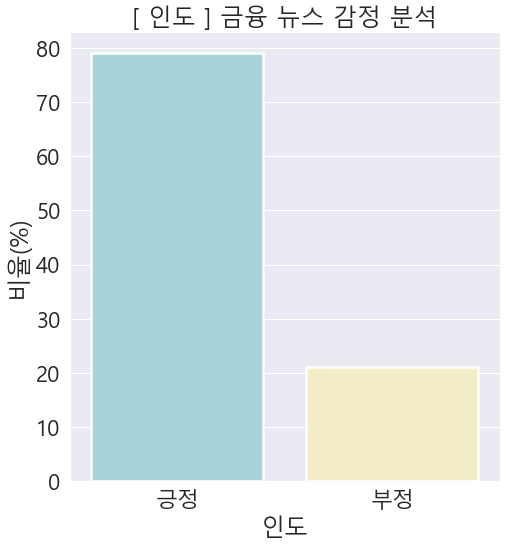

In [72]:

ax = sns.barplot( data = india[india['국가']=='인도'], linewidth = 2.5)
ax.set_title("[ 인도 ] 금융 뉴스 감정 분석")
ax.set_xlabel('인도')
ax.set_ylabel('비율(%)')
plt.savefig('save2.png', dpi=300)

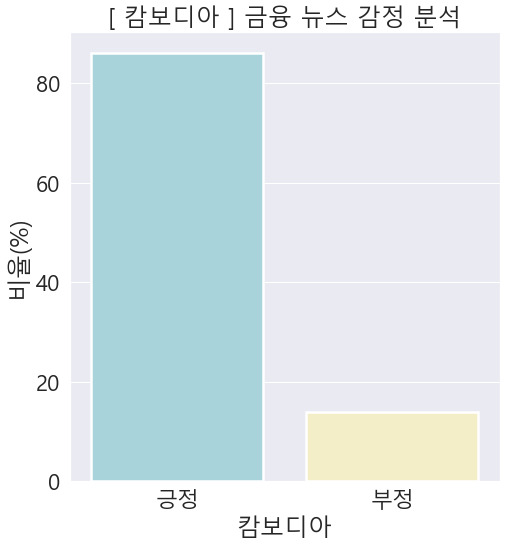

In [73]:
ax = sns.barplot( data = india[india['국가']=='캄보디아'],linewidth = 2.5)
ax.set_title("[ 캄보디아 ] 금융 뉴스 감정 분석")
ax.set_xlabel('캄보디아')
ax.set_ylabel('비율(%)')
plt.savefig('save3.png', dpi=300)

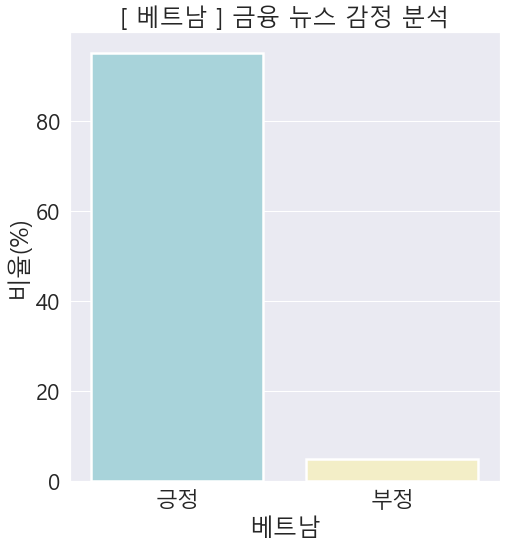

In [74]:
ax = sns.barplot( data = india[india['국가']=='베트남'],linewidth = 2.5)
ax.set_title("[ 베트남 ] 금융 뉴스 감정 분석")
ax.set_xlabel('베트남')
ax.set_ylabel('비율(%)')
plt.savefig('save4.png', dpi=300)